### Data-driven optimization and decision making

### Final project

Juha Reinikainen

In [13]:
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.visualization.pcp import PCP
import numpy as np

import model
import data
import algorithm

# import warnings
# warnings.simplefilter("ignore")

# reload changes to self written files
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df, esg = data.get_data_df()
dfTrain = df[:"2022-01-03"]
dfTest = df["2022-01-03":]

n_stocks = df.shape[1]
population_size = 100
n_generations = 1000
min_weight = 0.01
max_weight = 0.8
min_stocks = 4
max_stocks = 20
predictionPeriod = 12 # 3 * 4 = 12 weeks = 3 months

#weight for each stock and whether to 
variable_type_mask = ["real" for _ in range(n_stocks)] + ["bin" for _ in range(n_stocks)]

sampling = MixedVariableSampling(variable_type_mask, {
    "real": get_sampling("real_random"),
    "bin": get_sampling("bin_random")
})

crossover = MixedVariableCrossover(variable_type_mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "bin": get_crossover("bin_two_point")
})

mutation = MixedVariableMutation(variable_type_mask, {
    "real": get_mutation("real_pm", eta=3.0, prob=1/50),
    "bin": get_mutation("bin_bitflip", prob=1/50)
})
# problem = model.PortfolioSelection(df, esg, min_weight, max_weight, min_stocks, max_stocks, n_stocks)

# compute error of model
problemWithArima = model.PortfolioSelectionWithArima(dfTrain, esg, min_weight, max_weight, min_stocks, max_stocks, n_stocks, predictionPeriod)
predictionError = problemWithArima.predictionScore(dfTest)
print("model mean absolute error", predictionError)

# retrain with whole dataset
problemWithArima = model.PortfolioSelectionWithArima(df, esg, min_weight, max_weight, min_stocks, max_stocks, n_stocks, predictionPeriod)

repairMethod = algorithm.OneSumRepair(min_weight, max_weight, n_stocks)

model mean absolute error 0.10092185623749314


In [15]:
# initial_population = algorithm.createInitialPopulation(population_size, n_stocks)
nsga2 = NSGA2(
    pop_size = population_size, 
    sampling=sampling,
    crossover = crossover,
    mutation = mutation,
    repair = repairMethod
)
# res = minimize(problem, nsga2, ("n_gen", n_generations), seed=1, verbose = True)
res = minimize(problemWithArima, nsga2, ("n_gen", n_generations), seed=1, verbose = True)



n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  5.010000000 |       5 |            - |            -
    2 |     200 |  0.00000E+00 |  1.590000000 |       6 |  0.605073370 |        ideal
    3 |     300 |  0.00000E+00 |  0.220000000 |       4 |  0.704046369 |        ideal


c:\Users\Juha Reinikainen\Documents\dataopt\env\lib\site-packages\pymoo\operators\crossover\sbx.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


    4 |     400 |  0.00000E+00 |  0.00000E+00 |       9 |  0.235992804 |        ideal
    5 |     500 |  0.00000E+00 |  0.00000E+00 |       9 |  0.303993986 |        ideal
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      22 |  0.156995105 |        ideal
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      36 |  0.028842099 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      25 |  0.134227303 |        ideal
    9 |     900 |  0.00000E+00 |  0.00000E+00 |      36 |  0.024826170 |        ideal
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      53 |  0.089908772 |        ideal
   11 |    1100 |  0.00000E+00 |  0.00000E+00 |      59 |  0.191404336 |        ideal
   12 |    1200 |  0.00000E+00 |  0.00000E+00 |      72 |  0.110093767 |        ideal
   13 |    1300 |  0.00000E+00 |  0.00000E+00 |      98 |  0.042886301 |        ideal
   14 |    1400 |  0.00000E+00 |  0.00000E+00 |      97 |  0.005602553 |        ideal
   15 |    1500 |  0.00000E+00 |  0.00000E+00 |     10

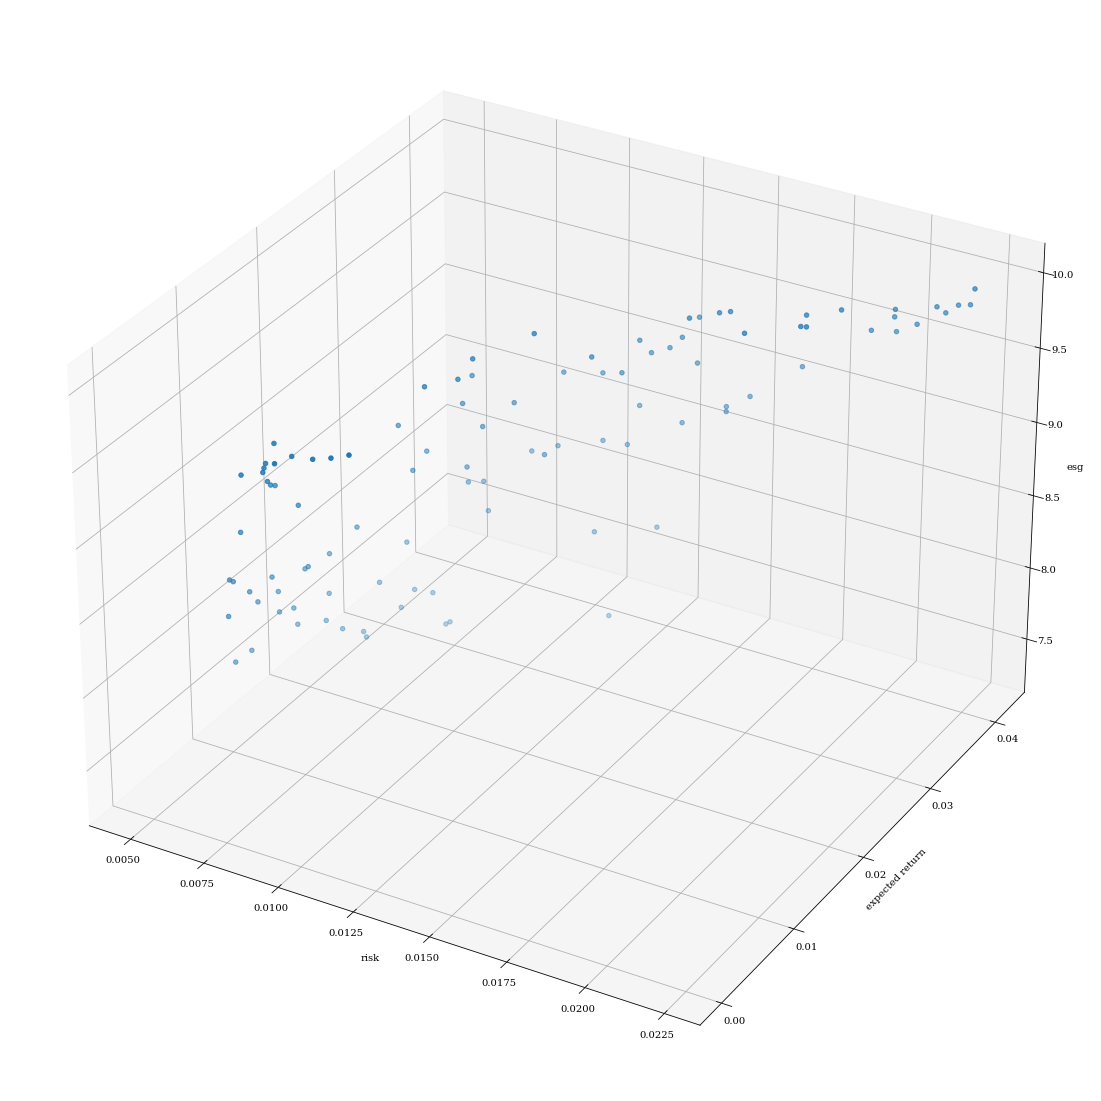

In [16]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.scatter(res.F[:,1], -res.F[:,0], -res.F[:,2])
ax.set_xlabel("risk")
ax.set_ylabel("expected return")
ax.set_zlabel("esg")
plt.show()

In [17]:
Wfinal = res.X[:,:n_stocks]
Yfinal = res.X[:,n_stocks:]
WYfinal = res.X[:,:n_stocks] * res.X[:, n_stocks:] 
#weights add to one?
print((WYfinal).sum(axis=1))

nStocksInEachSolution = Yfinal.sum(axis=1)
#number of stocks between min_stocks and max_stocks?
print(np.logical_and(nStocksInEachSolution >= min_stocks, nStocksInEachSolution <= max_stocks))

[1.0 0.9999999999999998 1.0 0.9999999999999999 1.0 1.0 1.0 1.0
 1.0000000000000002 1.0 1.0 0.9999999999999998 0.9999999999999998
 0.9999999999999999 0.9999999999999999 0.9999999999999999
 1.0000000000000002 1.0 1.0 1.0 0.9999999999999999 0.9999999999999999 1.0
 1.0 1.0 1.0 0.9999999999999996 0.9999999999999998 1.0 1.0 1.0 1.0
 0.9999999999999998 1.0 1.0000000000000002 1.0000000000000002
 0.9999999999999997 1.0 1.0 1.0000000000000002 0.9999999999999999 1.0 1.0
 0.9999999999999997 1.0 1.0 0.9999999999999999 0.9999999999999999
 0.9999999999999998 1.0 1.0 1.0 1.0000000000000002 1.0000000000000002 1.0
 1.0 1.0 1.0000000000000002 1.0 1.0 0.9999999999999997 1.0 1.0
 0.9999999999999996 1.0 1.0000000000000002 1.0000000000000002 1.0 1.0 1.0
 0.9999999999999998 1.0000000000000002 1.0 0.9999999999999998
 1.0000000000000004 1.0000000000000002 0.9999999999999998 1.0 1.0 1.0
 1.0000000000000002 1.0000000000000002 1.0 1.0 1.0 0.9999999999999998 1.0
 1.0000000000000002 0.9999999999999999 0.999999999999

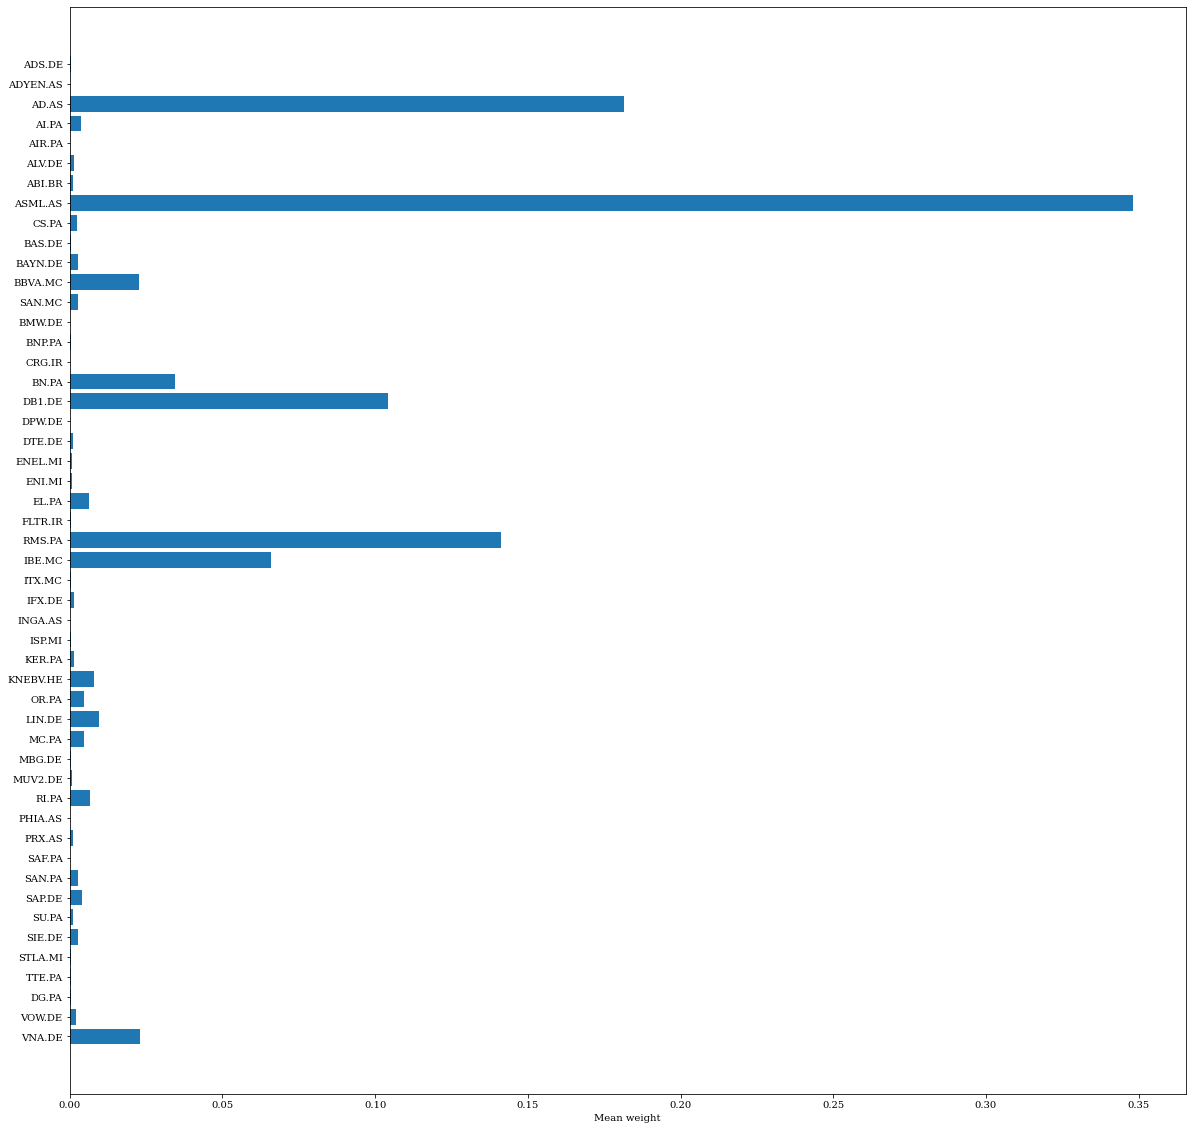

In [18]:
#mean weight for each stock
Wmean = WYfinal.mean(axis=0)
fig, ax = plt.subplots(figsize=(20,20))
ax.barh(range(len(Wmean)), Wmean)
ax.set_yticks(range(len(Wmean)), labels=data.STOCKNAMES)
ax.invert_yaxis()
ax.set_xlabel("Mean weight")

plt.show()

0.04162865131928816 0.0001299205489032137
0.004851040606838889 0.02234027777362805
9.998231940291463 7.3179134197197255
(100, 3)


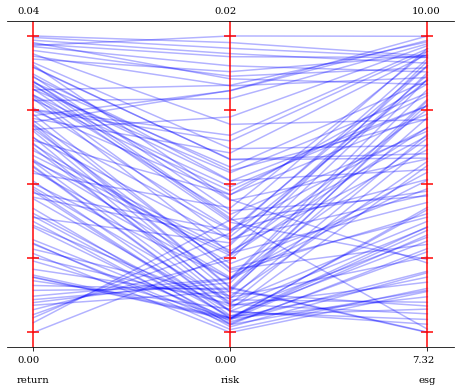

In [23]:
print(-res.F[:,0].min(),-res.F[:,0].max())
print(res.F[:,1].min(),res.F[:,1].max())
print(-res.F[:,2].min(),-res.F[:,2].max())
FPCP = np.array([-res.F[:,0], res.F[:,1], -res.F[:,2]]).T
print(FPCP.shape)
pcpPlot = PCP(labels=["return", "risk", "esg"])
pcpPlot.add(FPCP, color="blue", alpha=0.3)
# pcpPlot.add(FPCP[57], linewidth=5, color="red")
pcpPlot.show()

In [20]:
np.save("./data/F.npy", res.F)

In [21]:
portfolioWeights = WYfinal[57]
portfolioObjValues = FPCP[57]

In [22]:
print(portfolioWeights)
sizeIs = [i for i in range(len(portfolioWeights)) if not np.isclose(portfolioWeights[i], 0.0)]
sizes = portfolioWeights[sizeIs]
names = np.array(data.STOCKNAMES)[sizeIs]
for weight,nameOfStock in zip(sizes, names):
    print(nameOfStock, weight)

print()
print("return",portfolioObjValues[0])
print("risk",portfolioObjValues[1])
print("ESG score",portfolioObjValues[2])
# _,plt.pie(sizes, labels = names, autopct='%1.1f%%')
# plt.show()

[0.0 0.0 0.2376633159362579 0.013831668379296455 0.0 0.0 0.0
 0.035819381413772056 0.0 0.013831668379296455 0.0 0.09636394857232701 0.0
 0.0 0.0 0.0 0.01650504128004386 0.0 0.0 0.0 0.0 0.0 0.0180177227899276
 0.0 0.21162646952569827 0.25431437563365067 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.013831668379296455 0.013831668379296455 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.013831668379296455 0.013831668379296455 0.0 0.0
 0.04669973457254394]
AD.AS 0.2376633159362579
AI.PA 0.013831668379296455
ASML.AS 0.035819381413772056
BAS.DE 0.013831668379296455
BBVA.MC 0.09636394857232701
BN.PA 0.01650504128004386
EL.PA 0.0180177227899276
RMS.PA 0.21162646952569827
IBE.MC 0.25431437563365067
LIN.DE 0.013831668379296455
MC.PA 0.013831668379296455
STLA.MI 0.013831668379296455
TTE.PA 0.013831668379296455
VNA.DE 0.04669973457254394

return 0.015102550812879256
risk 0.006377151904788382
ESG score 8.268027938147043
